# Advanced model
The advanced model was run on google collab

## We begin by importing our data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

#runtime 1 min
data_train = pd.read_csv("/content/drive/My Drive/995,000_rows_preprocessed_train.csv", usecols=["type", "content"]) #Read the CSV file
data_val = pd.read_csv("/content/drive/My Drive/995,000_rows_preprocessed_valid.csv", usecols=["type", "content"]) #Read the CSV file
data_test = pd.read_csv("/content/drive/My Drive/995,000_rows_preprocessed_test.csv", usecols=["type", "content"]) #Read the CSV file


## We validate our data and find the median length

In [5]:
print(data_train['content'])
print(data_val['content'])
print(data_test['content'])

average_length = data_train['content'].apply(len).median()

print(f"Median length: {average_length}")


0         ['news', 'presid', 'obama', 'hillari', 'clinto...
1         ['local', 'area', 'man', 'afraid', 'woman', 'm...
2         ['belhanda', 'north', 'london', 'outfit', "'s"...
3         ['appl', 'iphon', '<num>', 'pre-ord', 'success...
4         ['fight', 'night', 'bad', 'box', 'make', 'good...
                                ...                        
408205    ['fourth', 'weekend', 'theater', ',', '—', '62...
408206    ['govern', 'releas', 'retail', 'sale', 'report...
408207    ['�risk�', 'fill', 'ib', 'esa', 'transfer', 'm...
408208    ['februari', ',', 'nasa', 'announc', 'discover...
408209    ['categori', '#', 'cruzsexscand', '$', '$', '<...
Name: content, Length: 408210, dtype: object
0        ['social', 'secur', 'built', 'array', 'broken'...
1        ['<num>', 'views0', 'like', '<url>', 'resid', ...
2        ["'", 'alway', 'feel', 'better', 'exercis', 'm...
3        ['refocu', 'note', ':', '’', 'west', ',', 'mid...
4        ['•', 'hain', 'celesti', 'group', ',', 'inc.',...


## We then Classify our types into binary. We use 1 for reliable news, 0 for fake news. Check for missing values and them to 0.0

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load your dataset (assuming df is your DataFrame)
#df = data.dropna(subset=['type', 'content']).copy()

def Classificationtype(df):
  df['type'] = df['type'].map({
      'unreliable': 0.0,
      'fake': 0.0,
      'clickbait': 1.0,
      'conspiracy': 0.0,
      'bias': 0.0,
      'hate': 0.0,
      'junksci': 0.0,
      'political': 1.0,
      'unknown': 0.0,
      'reliable': 1.0
  })

  # Replace NaN values with "unknown"
  df.fillna(0.0, inplace=True)

  # Verify the changes
  df.info()


Classificationtype(data_train)
Classificationtype(data_val)
Classificationtype(data_test)

print(sum(data_train['type']))
print(sum(data_val['type']))
print(sum(data_test['type']))



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408210 entries, 0 to 408209
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   type     408210 non-null  float64
 1   content  408210 non-null  object 
dtypes: float64(1), object(1)
memory usage: 6.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51026 entries, 0 to 51025
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   type     51026 non-null  float64
 1   content  51026 non-null  object 
dtypes: float64(1), object(1)
memory usage: 797.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51027 entries, 0 to 51026
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   type     51027 non-null  float64
 1   content  51027 non-null  object 
dtypes: float64(1), object(1)
memory usage: 797.4+ KB
121335.0
15227.0
15085.0


##  accordance with Zipf’s law2, we limit the vocabulary to the top 10,000 most frequent words in the Fake News corpus and pad sequences to the median article length of 1,700 tokens. We also extract the types from the train subset.

In [21]:
# Fit tokenizer on training data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(data_train['content'])

# Convert texts to sequences using the same tokenizer
X_train_seq = tokenizer.texts_to_sequences(data_train['content'])
X_val_seq = tokenizer.texts_to_sequences(data_val['content'])
X_test_seq = tokenizer.texts_to_sequences(data_test['content'])

# Padding sequences
X_padded_train = pad_sequences(X_train_seq, maxlen=1700)
X_padded_val = pad_sequences(X_val_seq, maxlen=1700)
X_padded_test = pad_sequences(X_test_seq, maxlen=1700)

y = data_train['type'].values
#Runtime med 995,000 rows 11 min 45 sec

# save tokenizer

In [ ]:
import pickle

# Save the tokenizer to a file
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

print("Tokenizer saved successfully!")

## Reassign the different value to fit the model

In [23]:
X_train = X_padded_train
X_test = X_padded_test
X_val = X_padded_val
y_train = data_train['type'].values
y_test = data_test['type'].values
y_val = data_val['type'].values

## Constrcuting the advanced model using a  hybrid LSTM (Long Short-Term Memory) and FNN (Feed-forward Neural Network) architecture

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Embedding(input_dim=10000, output_dim=128),  # Word embeddings
    LSTM(128),  # Sequence modeling on abstracted features
    Dropout(0.6),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


## training the model with 10 epochs and a batch size of 600.

In [26]:
model.fit(X_train, y_train, epochs=10, batch_size=600, validation_data=(X_val, y_val))


Epoch 1/10
681/681 ━━━━━━━━━━━━━━━━━━━━ 77s 109ms/step - accuracy: 0.8015 - loss: 0.4158 - val_accuracy: 0.8540 - val_loss: 0.3153
Epoch 2/10
681/681 ━━━━━━━━━━━━━━━━━━━━ 73s 107ms/step - accuracy: 0.8694 - loss: 0.2870 - val_accuracy: 0.8788 - val_loss: 0.2616
Epoch 3/10
681/681 ━━━━━━━━━━━━━━━━━━━━ 73s 108ms/step - accuracy: 0.8961 - loss: 0.2318 - val_accuracy: 0.8906 - val_loss: 0.2450
Epoch 4/10
681/681 ━━━━━━━━━━━━━━━━━━━━ 73s 108ms/step - accuracy: 0.9038 - loss: 0.2138 - val_accuracy: 0.8930 - val_loss: 0.2398
Epoch 5/10
681/681 ━━━━━━━━━━━━━━━━━━━━ 73s 107ms/step - accuracy: 0.8904 - loss: 0.2414 - val_accuracy: 0.8865 - val_loss: 0.2508
Epoch 6/10
681/681 ━━━━━━━━━━━━━━━━━━━━ 73s 108ms/step - accuracy: 0.9134 - loss: 0.1933 - val_accuracy: 0.8896 - val_loss: 0.2522
Epoch 7/10
681/681 ━━━━━━━━━━━━━━━━━━━━ 73s 108ms/step - accuracy: 0.9107 - loss: 0.1967 - val_accuracy: 0.8883 - val_loss: 0.2475
Epoch 8/10
681/681 ━━━━━━━━━━━━━━━━━━━━ 74s 108ms/step - accuracy: 0.9205 - loss: 0

## calculating accuracy, confusion matrix and f1-score

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Predict on the test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:\n", conf_matrix)


1595/1595 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - accuracy: 0.8953 - loss: 0.2577
Test Accuracy: 89.54%
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step
F1 Score: 0.82
Confusion Matrix:
 [[33516  2426]
 [ 2911 12174]]


## Check for overfitting - slight overfitting, however it's an acceptable amount

In [28]:
from sklearn.metrics import f1_score

# For training set
y_train_pred = (model.predict(X_train) > 0.5).astype("int32")
f1_train = f1_score(y_train, y_train_pred)

# For test set
y_test_pred = (model.predict(X_test) > 0.5).astype("int32")
f1_test = f1_score(y_test, y_test_pred)

print(f"F1 Score (Train): {f1_train:.2f}")
print(f"F1 Score (Test): {f1_test:.2f}")


12757/12757 ━━━━━━━━━━━━━━━━━━━━ 257s 20ms/step
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step
F1 Score (Train): 0.90
F1 Score (Test): 0.82


## Roc Curve

1595/1595 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step


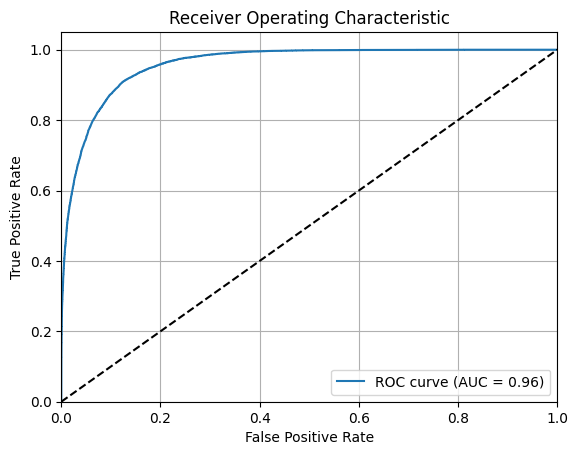

In [29]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities (not classes)
y_pred_proba = model.predict(X_test)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid()
plt.show()


## Save model

In [30]:
model.save('my_model_v2.keras')  # Use .h5 extension



Link to colab https://colab.research.google.com/drive/15SFTOJklc6EVGa7HaUN7HCdAehnE07Lj